In [1]:
from get_sentiment import *
plt.style.use('ggplot')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/dizquierdo/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
with open('data/tweets.json', 'r') as f:
    data = json.load(f)

In [3]:
clean_tweets, tag_set = cluster_flocks(data)

In [4]:
tag_set.most_common(5)

[('#auspol', 359),
 ('#Australia', 350),
 ('#ClimateCrisis', 290),
 ('#ClimateActionNow', 271),
 ('#straya', 257)]

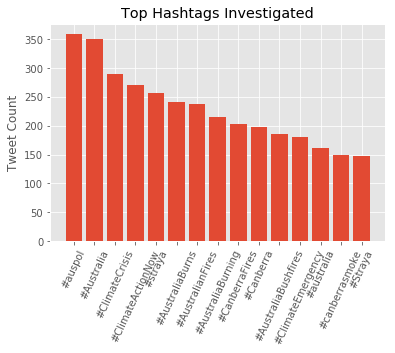

In [5]:
plt.bar([tag[0] for tag in tag_set.most_common(15)], [tag[1] for tag in tag_set.most_common(15)])
plt.xticks(rotation=65)
plt.ylabel('Tweet Count')
plt.title('Top Hashtags Investigated')
plt.show;

In [6]:
word_count = Counter(" ".join([re.sub(r'\s',' ',tweet[0]).strip() for tweet in clean_tweets]).split())

In [7]:
word_count.most_common(10)

[('the', 2174),
 ('to', 1612),
 ('of', 1041),
 ('a', 985),
 ('in', 966),
 ('and', 962),
 ('is', 721),
 ('for', 681),
 ('on', 452),
 ('this', 380)]

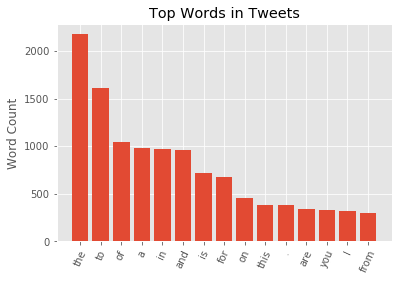

In [8]:
plt.bar([word[0] for word in word_count.most_common(15)], [word[1] for word in word_count.most_common(15)])
plt.xticks(rotation=65)
plt.ylabel('Word Count')
plt.title('Top Words in Tweets')
plt.show();

In [9]:
stopwords_list=stopwords.words('english') +list(string.punctuation)
stopwords_list += ["&amp;","'",'"','...','``','…','’','‘','“',"''",'""','”','”','co',"'s'",'\'s','n\'t','\'m','\'re','amp','https']
    

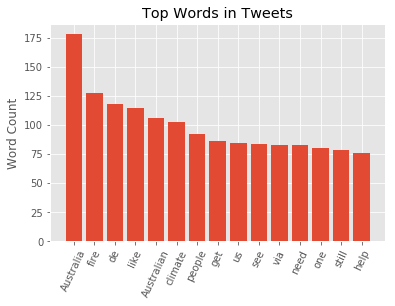

In [10]:
plt.bar([word[0] for word in word_count.most_common(100) if word[0].lower() not in stopwords_list][:15], [word[1] for word in word_count.most_common(100) if word[0].lower() not in stopwords_list][:15])
plt.xticks(rotation=65)
plt.ylabel('Word Count')
plt.title('Top Words in Tweets')
plt.show;

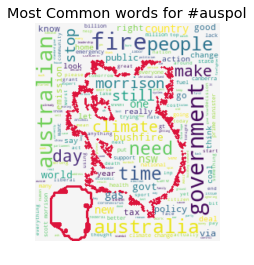

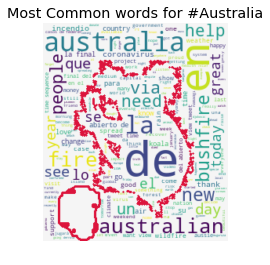

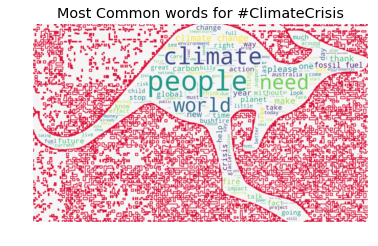

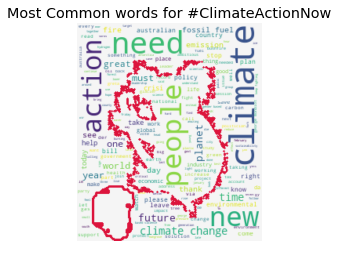

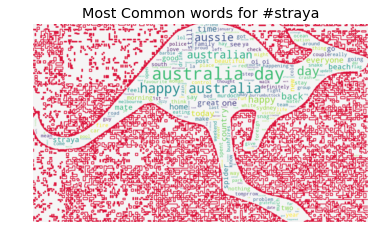

In [11]:
for tag in tag_set.most_common(5):
    subset = list(filter(lambda x: tag[0] in x[1], clean_tweets))
    create_wordcloud([tweet[0] for tweet in subset] , tag[0], 200)